# <font color='#31A67F'>EM for Gaussian Mixture Models</font>

## <font color='#A331A6'>I - Introduction</font> <br>
A __Gaussian mixture model__ is considered as a simple linear superposition of Gaussian components aiming at providing a richer class of density models than a single Gaussian. In general, a mixture model is a probabilistic model for representing the presence of subpopulations within an overall population, without requiring that an observed data set should identify the sub-population to which an individual observation belongs. In this document, I will try to formulate Gaussian mixture models in terms of discrete latent variables. Therefore, a Gaussian mixture distribution can be written as a linear suporposition of Gaussians as follows : <br>
$$
\begin{equation*}
p(x) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k , \Sigma_k )
\end{equation*}
$$
In the previous expression, the terms $\pi_k \in [0,1]$ are the weights corresponding to each of the K Gaussian components. We shall view the $\pi_k$ as *the prior probability of belonging the the $k$-th Gaussian component*. <br>
We shall now introduce the following quantities : <br>
$$
\begin{equation*}
\gamma_i(x) = \frac{\pi_i \mathcal{N}(x | \mu_i , \Sigma_i )}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x | \mu_j , \Sigma_j )}
\end{equation*}
$$
If we are placed in a bayesian context, these quantities correspond to the posterior probability of belonging to a component once we have observed our dataset. <br>
In this document, I will study the Gaussian Mixture Models by generating random samples distributed according to the model with given values of the parameters. Then, assuming we only have the data and we lost the values of the parameters, I will use the __Expectation Maximization__ algorithm to find the maximum likelihood solutions for models with latent variables.

## <font color='#A331A6'>II - Theoretical study</font> <br>
Assuming we have $K$ Gaussian components, the quantities $\{\gamma_k\}_{k=1}^{K}$ are often needed to be evaluated. Yet, a direct computation of these quantities might be problematic in practice since all the terms $(\pi_i \mathcal{N} (x; \mu_i , \Sigma_i))$ might be very small, and we might end up with $0/0$. In order to remediate this issue, we shall start by computing the logarithm of these quantites in a mathematically stable way.<br>
$$
\begin{equation*}
    log(\gamma_i (x)) = log(\pi_i \mathcal{N} (x; \mu_i , \Sigma_i)) - log(\sum_{j=1}^K \pi_j \mathcal{N} (x; \mu_j , \Sigma_j))
    = l_i - log(\sum_{j=1}^K exp(l_j))
\end{equation*}
$$
In order to evaluate the second term, we only need to compute the first term $l_i$ and then use the function *logsumexp* presented in the previous document. Note that $\mathcal{N}$ is the gaussian multivariate distribution defined by : $\mathcal{N} (x; \mu_i , \Sigma_i)) = \frac{1}{(2\pi)^{N/2} |\Sigma_i|^{1/2}} exp(\frac{-1}{2} (x - \mu_i) \Sigma_i^{-1} (x - mu_i)^T)$, where $x \in \mathbb{R}^N $<br><br>
$\Rightarrow l_i = log(\pi_i) - \frac{N}{2} log(2 \pi) - \frac{1}{2}log(|\Sigma_i|) - \frac{1}{2} (x - \mu_i) \Sigma_i^{-1} (x - mu_i)^T$ <br><br>
It is important to mention that computing the logarithm of the determinant of $\Sigma_i$ is numerically stable. In fact, if an array has a very small or very large determinant, then a call to det may overflow or underflow. With python, computing this quantity is very simple using *numpy.linalg.slogdet* which returns the signe and the natural log of the absolute value of the determinant.<br><br>
Now, theoretically speaking, computing the logarithm of the determinant of a matrix may be done using the __Cholesky decomposition__ which assumes that, given a Hermitian positive-definite matrix A, we have the following decomposition ${\displaystyle \mathbf {A} =\mathbf {LL} ^{T},}$ where $L$ is a lower triangular matrix with real and positive diagonal entries, and $L^T$ denotes the conjugate transpose of $L$.<br>
In our case, the covariance $\Sigma_i$ is positive-definite. Thus, we can use the Cholesky decomposition. If $L$ is the corresponding triangular matrix, we have this elegant relation between its terms :<br>
$$
\begin{align}
    &{\displaystyle L_{j,j}={\sqrt {\Sigma_{j,j}-\sum _{k=1}^{j-1}L_{j,k}^{2}}}}\\
&{\displaystyle L_{i,j}={\frac {1}{L_{j,j}}}\left(\Sigma_{i,j}-\sum _{k=1}^{j-1}L_{i,k}L_{j,k}\right)\quad {\text{for }}i>j.} 
\end{align}
$$
Now we return to our expression of the logarithm of the determinant, we use the decomposition above to compute the quantity :<br><br>
$$
\begin{align}
    log(|\Sigma_i|) & = log(|\mathbf {LL} ^{T}|) \\
    & = log(|\mathbf {L}||\mathbf {L}|)\\
    & = 2 log(|\mathbf {L}|)\\
    & = 2 \displaystyle\prod_{j=1}^{N}{\displaystyle L_{j,j}}
\end{align}
$$

We continue to consider the Gaussian mixture model defined above by : <br> 
$$
\begin{equation*}
p(x_n) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k )
\end{equation*}
$$
where $\{x_n\}_{n=1}^{N}$ is the set of the observed points. In order to establish the Expectation Maximization algorithm, we need to find the expressions of $\pi_{1:K}$, $\mu_{1:K}$, $\Sigma_{1:K}$ for each time step. To do so, we consider the logarithm of the likelihood function given by : <br>
$$
\begin{equation*}
log(p(X;\pi, \mu, \Sigma)) = \sum_{n=1}^{N} log ( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) )
\end{equation*}
$$
Since the main goal of the Expectation Maximization algorithm is to maximize the likelihood (the log likelihood), we consider deriving the expression of the log likelihood with reference to each parameter and set to zero in order to obtain the exact expression. <br>

### <font color='Maroon'>Deriving with reference to $\mu_k$ 

$$
\begin{align}
    \frac{\partial log(p(X;\pi, \mu, \Sigma))}{\partial \mu_k} & = \sum_{n=1}^{N} \frac{1}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } \frac{\partial}{\partial \mu_k}( \sum_{k=1}^{K} \pi_k \frac{1}{(2\pi)^{N/2} |\Sigma_k|^{1/2}} exp(\frac{-1}{2} (x_n - \mu_k) \Sigma_i^{-1} (x_n - \mu_k)^T) )\\
 &=^{(a)} \sum_{n=1}^{N} \frac{- \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k )}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } \Sigma_{k}^{-1}(x_n - \mu_k) = 0 
 \end{align}\\
 
 \Rightarrow \sum_{n=1}^{N} \gamma_k(x_n) \Sigma_{k}^{-1}(x_n - \mu_k) = 0\\
 \Rightarrow^{(b)} \sum_{n=1}^{N} \gamma_k(x_n) (x_n - \mu_k) = 0\\
 \Rightarrow \sum_{n=1}^{N} \gamma_k(x_n) x_n - \sum_{n=1}^{N} \gamma_k(x_n) \mu_k = 0\\
 \Rightarrow \mu_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma_k(x_n) x_n
 $$
 where $N_k = \sum_{n=1}^{N} \gamma_k(x_n) $. <br> <br>
 $\bullet $ (a) : We use the fact that $(e^{u})' = u' e^{u}$<br>
 $\bullet $ (b) : We multiply the expression by $\Sigma_k$<br>
 
### <font color='Maroon'> Deriving with reference to $\Sigma_k$

$$
\begin{align}
    \frac{\partial log(p(X;\pi, \mu, \Sigma))}{\partial \Sigma_k} &= \sum_{n=1}^{N} \frac{1}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } \frac{\partial}{\partial \Sigma_k}( \sum_{k=1}^{K} \pi_k \frac{1}{(2\pi)^{N/2} |\Sigma_k|^{1/2}} exp(\frac{-1}{2} (x_n - \mu_k) \Sigma_i^{-1} (x_n - \mu_k)^T) )\\
&= \sum_{n=1}^{N} \frac{1}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) }  \frac{\pi_k}{(2\pi)^{N/2}} \left( \frac{-\Sigma_k |\Sigma_k|}{|\Sigma_k|^{3/2}} + (x_n - \mu_k)(x_n - \mu_k)^T) \right) exp(\frac{-1}{2} (x_n - \mu_k) \Sigma_i^{-1} (x_n - \mu_k)^T) )\\
&= \sum_{n=1}^{N} \frac{\pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k )}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } \left(- \Sigma_k +  (x_n - \mu_k)(x_n - \mu_k)^T) \right) \\
&= \sum_{n=1}^{N} \gamma_k(x_n) (-\Sigma_k + (x_n - \mu_k)(x_n - \mu_k)^T)) = 0 \\
&\Rightarrow \Sigma_k = \frac{1}{N_k} \sum_{n=1}^{N} \gamma_k(x_n) (x_n - \mu_k)(x_n - \mu_k)^T) 
\end{align}
$$<br>

### <font color='Maroon'> Deriving with reference to $\pi_k$

In order to maximize the log likelihood function with reference to $\pi_k$, we need to take into consideration the constraint put on the prior distributions saying that $\sum_{k=1}^{K} \pi_k = 1$. This task can be achieved by maximizing the Lagrangian : <br> 
$$
\begin{equation*}
    log(p(X;\pi, \mu, \Sigma)) + \lambda \left( \sum_{k=1}^{K} \pi_k - 1 \right)
\end{equation*}
$$
where $\lambda$ is the lagrange multiplier associated with the constraint. We now shall do the same as previously, deriving the langrangian wrt to $\pi_k$ and setting it to zero
$$
\begin{align}
    \frac{\partial log(p(X;\pi, \mu, \Sigma) + \lambda \left( \sum_{k=1}^{K} \pi_k - 1 \right)) }{\partial \pi_k} &= \sum_{n=1}^{N} \frac{\mathcal{N}(x_n | \mu_k , \Sigma_k )}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } + \lambda \\
    &= 0\\
    &\Rightarrow \sum_{n=1}^{N} \frac{\pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k )}{ \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k , \Sigma_k ) } + \pi_k \lambda = 0 \\
    &\Rightarrow \sum_{k=1}^{K} \sum_{n=1}^{N} \gamma_k(x_n) + \sum_{k=1}^{K} \pi_k \lambda = 0 \\
    &\Rightarrow \sum_{k=1}^{K} N_k + \lambda = 0 \\
    &\Rightarrow N + \lambda = 0 \\
    &\Rightarrow \lambda = -N \\
\end{align}
$$<br>
After substituting $\lambda$ with its value and rearranging the terms conviently, we easily obtain : <br>
$$
\begin{equation}
    \pi_k = \frac{N_k}{N}
\end{equation}
$$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# Function used to compute in a numerically stable way the denominator in the expression of gamma
def logsumexp(v):
    vmax = max(v)
    return vmax + np.log(sum(np.exp([x-vmax for x in v])))

# Function used to compute the log of the posterior distribution given a matrix x of observations and a set of parameters
# It returns the log_gamma and the log_likelihood useful in the EM algorithm
def log_gamma(x, Pi, mu, sigma):
    n = len(x[0])
    log_Pi = np.log(Pi)  
    log_likelihood = []
    res = []
    for e in x:
        log_numerator = []
        for i in range(len(pi)):
            C = -(n/2)*np.log(2*np.pi) - 0.5*np.linalg.slogdet(sigma[i])[1]
            P = (0.5)*(e-mu[i]).dot(np.linalg.inv(sigma[i])).dot(np.transpose(e-mu[i]))
            log_numerator.append(log_Pi[i] + C - P)
        log_denom = logsumexp(log_numerator)
        log_likelihood.append(log_denom)
        res.append(log_numerator - log_denom)
    return res, sum(log_likelihood)

## <font color='#A331A6'>III - Data generation and EM algorithm <br>
Once we have completely studied the Gaussian mixture model in a theoretical way, allowing us to compute the expressions of the parameters, I will be generating a population given certain quantities. In order to generate the dataset in a Gaussian mixture model context, I first generate a random integer $i$ covering the possible $K$ gaussian componenets. Then, using this randomly generated integer, I generate an individual row (i.e two componenets, since our population is in $\mathbb{R}^2$) following the gaussian componenent $i$. Doing this in a loop will return the whole population according the given gaussian mixture model. <br> 
The parameters used here are as follow : <br>
$\bullet$ $N = 0$ : size of the population. <br> 
$\bullet$ $K = 3$ : number of gaussian componenets. <br>
$\bullet$ $\pi = [0.3, 0.2, 0.5]$ : the prior distribution. <br>
$\bullet$ $\mathbf {\mu} ={\begin{bmatrix}0&0\\1&2\\2&0\end{bmatrix}}$. <br>
$\bullet$ $\mathbf {\Sigma_1} ={\begin{bmatrix}1&-0.25\\-0.25&0.5\end{bmatrix}}$ ; ${\Sigma_2} ={\begin{bmatrix}0.5&0.25\\0.25&0.5\end{bmatrix}}$ ; ${\Sigma_3} ={\begin{bmatrix}0.5&-0.25\\-0.25&1\end{bmatrix}}$ <br> 

In [3]:
N = 1000
pi = np.array([0.3, 0.2, 0.5])
K = len(pi)
mu_1 =[0,0]
mu_2 =[1,2]
mu_3 =[2,0]
mu = [mu_1, mu_2, mu_3]
sigma_1 = [[1.00, -0.25], [-0.25, 0.50]]
sigma_2 = [[0.50, 0.25], [0.25, 0.50]]
sigma_3 = [[0.50, -0.25], [-0.25, 1]]
sigma = [sigma_1, sigma_2, sigma_3]
x = [0 for e in range(N)]
for k in range(N):
    i = np.random.choice(np.arange(0,K), p=pi)
    x[k] = np.random.multivariate_normal(mu[i], sigma[i], 1)[0]

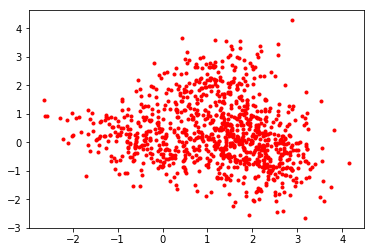

In [4]:
plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'r.')
plt.show()

The Expectation Maximization algorithm presents an elegant and powerful way for finding maximum likelihood solutions for models with latent variables or finding maximum aposteriori estimates of parameters. When using this algorithm, we suppose we only have our dataset and we forget about the parameters that gave birth to it. Our goal is to estimate these parameters in an iterative way alterning between an __E-step__ and an __M-step__. <br><br> 
$\bullet$ In the E-step, we will use the implemented function *log_gamma* to expect the log_likelihood computed with the current parameters. <br>
$\bullet$ In the M-step, we will update the parameters and try to maximize the expected log_likelihood function found in the E-step. We will be using the expressions that we found in the theoretical part. Finally, these estimated parameters will be used in the next E-step to determine the distribution of the latent variables. <br><br>
We will first need to initialize some random parameters. These parameters will come as an input for the EM algorithm that will update them in each M-step, maximizing the log_likelihood.<br>
In the Expectation Maximization algorithm, I will use a variable named max_iter for maximum iterations to avoid infinite loops. Besides, I will compute the log likelihood in each step and check the convergence.

In [5]:
# Defining the Expectation Maximization algorithm
def EM(x, pi, mu, sigma, N, K, max_iter):
    means = []
    covariances = []
    Pis = [] 
    objectif = []
    for i in range(max_iter):
        # E step
        log_gamma_t, likelihood = log_gamma(x, pi, mu, sigma)
        log_gamma_t = np.matrix(log_gamma_t)
        objectif.append(likelihood)
        X = np.matrix(x)
        # M step
        mu = np.transpose(np.exp(log_gamma_t))*X
        for k in range(K):
            mu[k] = mu[k]/(np.exp(log_gamma_t).sum(axis=0))[0,k]
            S = 0
            for j in range(N):
                S = S + np.exp(log_gamma_t)[j,k]*np.transpose(X[j]-mu[k]).dot(X[j]-mu[k])
            sigma[k] = (S / (np.exp(log_gamma_t).sum(axis=0))[0,k]).tolist()
            pi[k] = (1/N)*np.exp(log_gamma_t).sum(axis=0)[0,k]
        mu = mu.tolist()
        means.append(mu)
        covariances.append(sigma)
        Pis.append(pi)
        # Checking for convergence for epsilon = 0.01
        if i>0 and abs(objectif[i]-objectif[i-1]) < 0.01:
            break
    return (means, covariances, Pis, objectif)

In [6]:
# Initialiazing some random parameters to be used in the expectation maximization algorithm
def initialization(K, seed):
    mu_init = [0 for e in range(K)]
    np.random.seed(seed)
    for i in range(K):
        temp_mu = list(np.random.uniform(-3,3,2))
        mu_init[i] = temp_mu

    temp_sigma = np.random.uniform(-2,2)
    sigma_init = [[[temp_sigma*temp_sigma, 0], [0, temp_sigma*temp_sigma]], 
                  [[temp_sigma*temp_sigma, 0], [0, temp_sigma*temp_sigma]],
                 [[temp_sigma*temp_sigma, 0], [0, temp_sigma*temp_sigma]]]
    temp_pi = np.random.uniform(0, 1, 3)
    pi_1 = temp_pi[0]/sum(temp_pi)
    pi_2 = temp_pi[1]/sum(temp_pi)
    pi_3 = temp_pi[2]/sum(temp_pi)
    pi_init = np.array([pi_1, pi_2, pi_3])
    return mu_init, sigma_init, pi_init

In [7]:
mu_init, sigma_init, pi_init = initialization(K, 221)

### <font color='Maroon'>Plotting the contours with the initial values of the parameters

In [8]:
from scipy.stats import multivariate_normal

In [9]:
def plot_init(x, mu_init, sigma_init):
    plt.rcParams["figure.figsize"] = [8, 6]
    x1, y1 = np.mgrid[-4:5:.01, -4:5:.01]
    pos = np.empty(x1.shape + (2,))
    pos[:, :, 0] = x1; pos[:, :, 1] = y1

    plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'k.', zorder=1)

    rv_init = []
    colors = ['red', 'blue', 'green']

    for i in range(K):
        rv_init.append(multivariate_normal(mu_init[i], sigma_init[i]))
        plt.contour(x1, y1, rv_init[i].pdf(pos), 2, colors=colors[i], linewidths = 3)

    plt.title('Initialisation')

    plt.show()

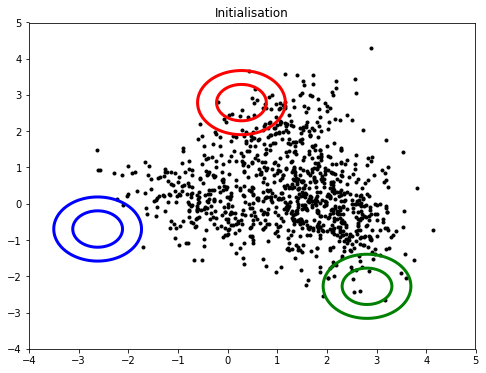

In [10]:
plot_init(x, mu_init, sigma_init)

In [11]:
means , covariances, Pis, objectif = EM(x, pi_init, mu_init, sigma_init, N, K, 500)

### <font color='Maroon'>Plotting the log likelihood function given by the EM algorithm

In [12]:
def plot_loglikelihood(objectif):
    plt.rcParams["figure.figsize"] = [8, 6]
    plt.plot(objectif[1:], 'r-')
    plt.title('Logarithm Likelihood')
    plt.show()

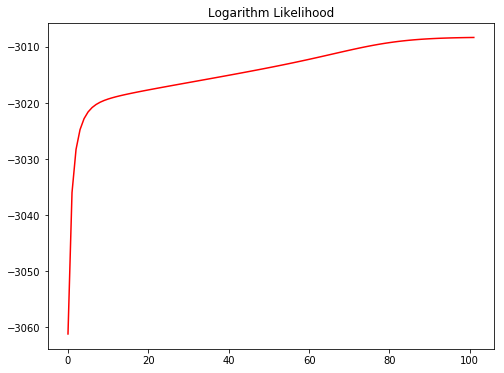

In [13]:
plot_loglikelihood(objectif)

We see in the plot above that le log likelihood is increasing. Then, at a certain stage, it converges to a value and seems to stabilize. We can say that our EM algorithm does converge.

### <font color='Maroon'>Plotting the contours of the gaussian componenents for different time steps

In [14]:
def plot_different_contours(objectif, means, covariances):
    plt.rcParams["figure.figsize"] = [16, 16]
    x1, y1 = np.mgrid[-4:5:.01, -4:5:.01]
    pos = np.empty(x1.shape + (2,))
    pos[:, :, 0] = x1; pos[:, :, 1] = y1
    j = len(objectif) // 10

    rv_first = []
    rv_second = []
    rv_third = []
    rv_final = []
    
    colors = ['red', 'blue', 'green']
    
    for i in range(K):
        rv_first.append(multivariate_normal(means[j][i], covariances[j][i]))
        rv_second.append(multivariate_normal(means[2*j][i], covariances[2*j][i]))
        rv_third.append(multivariate_normal(means[4*j][i], covariances[4*j][i]))
        rv_final.append(multivariate_normal(means[-1][i], covariances[-1][i]))

    plt.subplot(221)
    plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'k.', zorder=1)
    for i in range(K):
        plt.contour(x1, y1, rv_first[i].pdf(pos), 2, colors=colors[i], linewidths = 3)
    plt.title('First catch L = {}'.format(j))

    plt.subplot(222)
    plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'k.', zorder=1)
    for i in range(K):
        plt.contour(x1, y1, rv_second[i].pdf(pos), 2, colors=colors[i], linewidths = 3)
    plt.title('Second catch L = {}'.format(2*j))

    plt.subplot(223)
    plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'k.', zorder=1)
    for i in range(K):
        plt.contour(x1, y1, rv_third[i].pdf(pos), 2, colors=colors[i], linewidths = 3)
    plt.title('Third catch L = {}'.format(4*j))

    plt.subplot(224)
    plt.plot([x[e][0] for e in range(N)], [x[e][1] for e in range(N)], 'k.', zorder=1)
    for i in range(K):
        plt.contour(x1, y1, rv_final[i].pdf(pos), 2, colors=colors[i], linewidths = 3)
    plt.title('Final catch L = {}'.format(len(objectif)))

    plt.show()

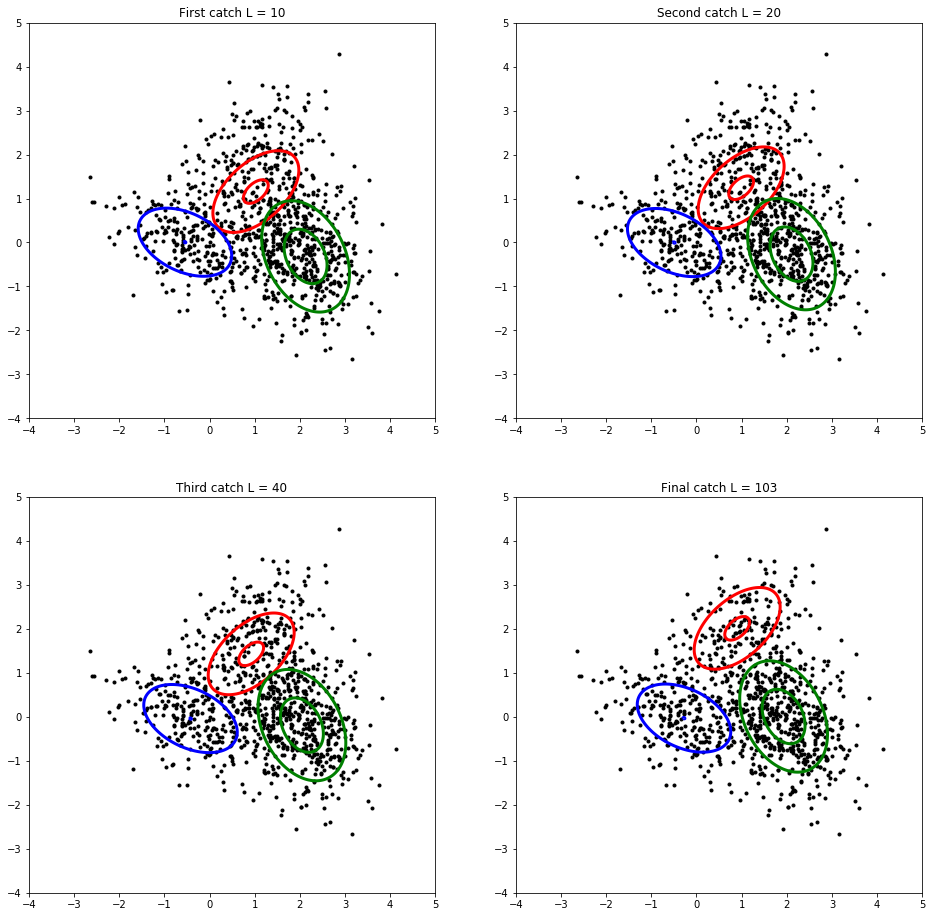

In [15]:
plot_different_contours(objectif, means, covariances)

### <font color='Maroon'> Running the algorithm and plotting with different initializations

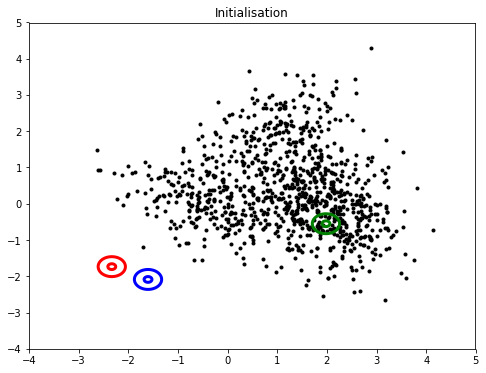

In [16]:
mu_init_1, sigma_init_1, pi_init_1 = initialization(K, 121)
plot_init(x, mu_init_1, sigma_init_1)

In [17]:
means , covariances, Pis, objectif = EM(x, pi_init_1, mu_init_1, sigma_init_1, N, K, 500)

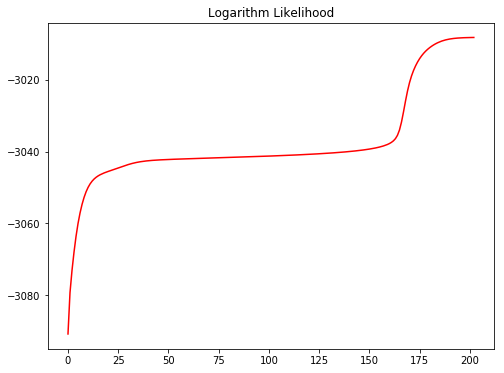

In [18]:
plot_loglikelihood(objectif)

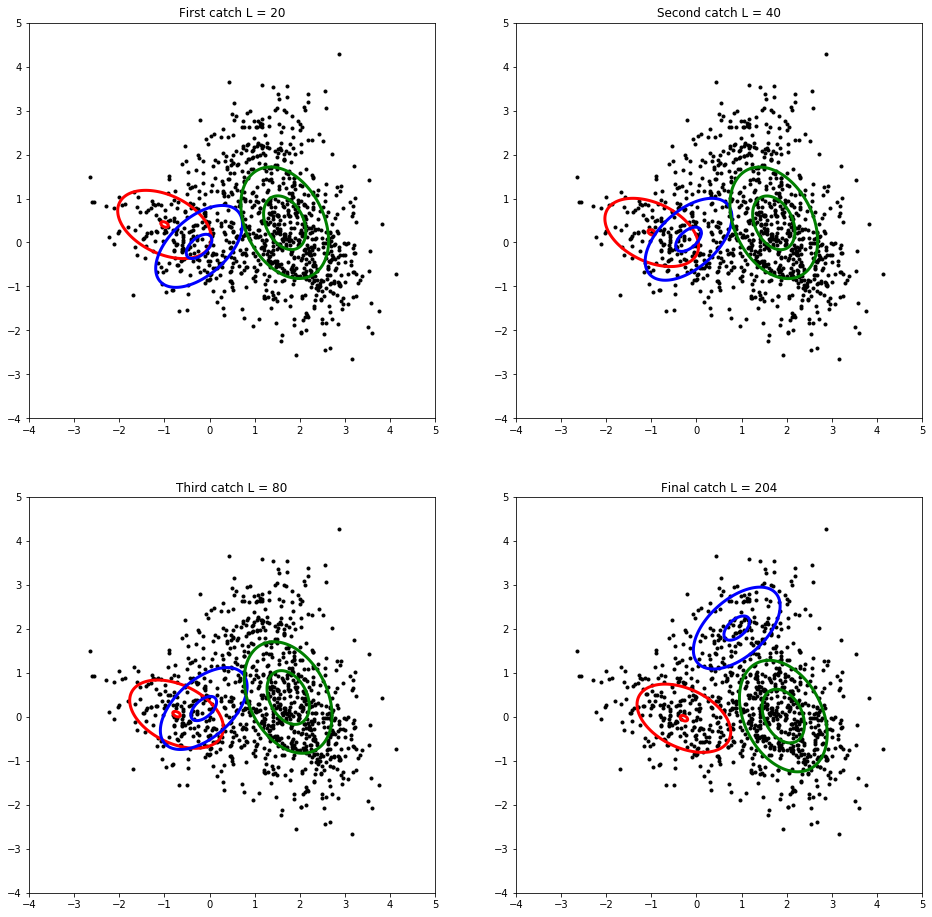

In [19]:
plot_different_contours(objectif, means, covariances)

## <font color='#A331A6'>IV - Conclusion <br>

When we change the values of the initial priors, means and covariances, we remark that the algorithm still converges to a maximum log likelihood but in different time steps. Thus, we can say that the algorithm is sensible to the initializations of the different parameters. In fact, the more the starting point is closer to the actual gaussian componenents, the faster the algorithm will converge <br><br> 
In this work, I tried to briefly show how effecient the EM algorithm was to handle the Gaussian mixture model problem. When having a population generated from an unknows gaussian mixture model, we can identify the different componenents (ie the different clusters) from which each point is original. In this way, we can easily apply clustering over this population. We have seen that the initialiazation is crucial and has a direct effect on the speed of convergence of the EM algorithm. Therefore, we can adjust our initialization, for exemple start with applying k-means algorithm to identify the best initial values of our parameters, then run the EM algorithm using these values to smoothly adjust the clustering. <br><br> <br>
*Ahmed Ak.*